In [1]:
from qiskit import *
from zero_noise_extrapolation import *
import numpy as np
import pylab as pl

In [2]:
import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

In [3]:
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

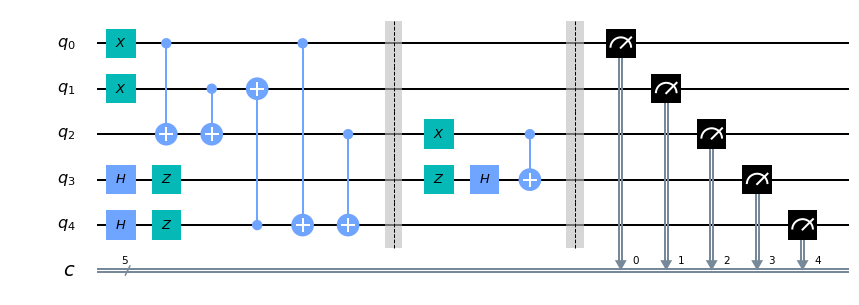

In [4]:
def get_maxs_poker_circuit(usebarrier=False, measure=True, applynotpos=-1):
    circ = "OPENQASM 2.0;\ninclude \"qelib1.inc\"; \
    qreg q[5];\
    creg c[5];"
    if applynotpos>-1 and applynotpos<5:
        circ = circ + "x q["+str(applynotpos)+"];"
    circ = circ + "x q[0];\
    x q[1];\
    h q[3];\
    z q[3];\
    h q[4];\
    z q[4];\
    cx q[0],q[2];\
    cx q[1],q[2];\
    cx q[4],q[1];\
    cx q[0],q[4];\
    cx q[2],q[4];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    circ = circ + "x q[2];\
    z q[3];\
    h q[3];\
    cx q[2],q[3];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    if measure:
        circ = circ + "measure q[0] -> c[0]; \
        measure q[1] -> c[1]; \
        measure q[2] -> c[2]; \
        measure q[3] -> c[3]; \
        measure q[4] -> c[4]; "
    qc = QuantumCircuit.from_qasm_str(circ)
    return qc

get_maxs_poker_circuit(True).draw(output='mpl')

In [5]:
backends_dict={}
noisemodels_dict={}
basis_gates_dict={}
cx_error_maps_dict={}

In [6]:
backendname_sim = 'qasm_simulator'
backends_dict[backendname_sim] = Aer.get_backend(backendname_sim)

#load IBMQ account
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backendname_x2 = 'ibmqx2'
backendname_ourense = 'ibmq_ourense'

for backendname in [backendname_x2, backendname_ourense]:
    backends_dict[backendname] = provider.get_backend(backendname)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model

for backendname in [backendname_x2, backendname_ourense]:
    backend = backends_dict[backendname]

    noisemodels_dict[backendname] = basic_device_noise_model(backend.properties())
    cx_error_maps_dict[backendname] = get_cx_error_map(backend)
    basis_gates_dict[backendname] = noisemodels_dict[backendname].basis_gates

noisemodels_dict['None'] = None

In [8]:
numones=np.zeros((2**5,1))
for i in range(2**5):
    numones[i]=bin(i).count("1")

In [9]:
def expectationValue(results, myfilter=None):
    #num_qubits = results[0].header.n_qubits
    E=np.zeros((len(results),1))
    if myfilter==None:
        for item in range(0,len(results)):
            shots = results[item].shots
            counts = results[item].data.counts
            for key in list(counts.__dict__.keys()):
                c=getattr(counts, key)#number of counts
                E[item] += numones[int(key,0)]*c/shots
    else:
        binres=convert_to_binarystring(results)
        for item in range(0,len(results)):
            binresfilt=myfilter.apply(binres[item])
            shots = results[item].shots
            for key in binresfilt:
                E[item] += numones[int(str(key),2)]*binresfilt[key]/shots
    return E

In [ ]:
R,E_dict,E_av_dict,max_depth_dict,mean_depth_dict,max_depth_transpiled_dict,mean_depth_transpiled_dict =\
mitigate(get_maxs_poker_circuit(), [1,2,4],\
             expectationValue,\
             backends_dict[backendname_sim], \
             "Poker", cx_error_maps_dict[backendname_x2],\
             8192, 1024,\
             backends_dict[backendname_x2],\
             noisemodels_dict[backendname_x2],\
             basis_gates_dict[backendname_x2],\
             )

Sanity checks passed
Result for job ' Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r1 ' successfully read from disk
Result for job ' Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r2 ' successfully read from disk
Could not read result for job ' Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r4 ' from disk
Creating circuits for ' Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r4 ' 1024 / 1024
Starting job for ' Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r4 '
Job Status: job is actively running

In [ ]:
bn="Poker_backendqasm_simulator_noisemodelibmqx2_shots8192_experiments1024_paulitwirlingTrue_r"

In [ ]:
font = {'size' : 16}
pl.matplotlib.rc('font', **font);
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(4+0*E_av_dict[bn+"1"],'k',label='ideal')
pl.plot(E_av_dict[bn+"1"],label='r=1')
pl.plot(E_av_dict[bn+"2"],':',label='r=2')
pl.plot(E_av_dict[bn+"4"],':',label='r=4')
R12=Richardson_extrapolate(np.array([E_av_dict[bn+"1"], E_av_dict[bn+"2"]]),np.array([1,2]))
pl.plot(R12[0],label='R(E1,E2)')
pl.plot(R,label='R(E1,E2,E4)')
pl.legend()

In [ ]:
xmin=0.95
numbins=100
d=pl.hist(E_dict[bn+"1"],edgecolor = 'black',color='green',range=(xmin,4.05),bins=numbins,\
                 alpha=.75,histtype='stepfilled',label='r=1')
d=pl.hist(E_dict[bn+"4"],edgecolor = 'black',color='blue',range=(xmin,4.05),bins=numbins,\
                 alpha=0.5,histtype='stepfilled',label='r=4')

In [ ]:
pl.plot((mean_depth_dict[bn+"1"],\
        mean_depth_dict[bn+"2"],\
        mean_depth_dict[bn+"4"]),label='mean depth')
pl.plot((mean_depth_transpiled_dict[bn+"1"],\
        mean_depth_transpiled_dict[bn+"2"],\
        mean_depth_transpiled_dict[bn+"4"]),label='mean depth after combining single qubit gates')
pl.legend()